# Imports

In [40]:
import pandas as pd
import numpy as np

import librosa
import librosa.display

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

# Load Feature File

This file contains multiple features that were used for exploration with a CNN ensemble. However, for this specific model, only the Mel Spectrogram feature will be used.

In [2]:
df = pd.read_pickle('features.csv')

In [3]:
df.head()

,file,label,mel_spec,chroma,mfcc
0,data/train/train1.aiff,0,"[[-23.034714, -21.979626, -21.229372, -24.6853...","[[0.31054255, 0.492938, 0.4222786, 0.2000359, ...","[[-583.5913, -585.6181, -586.71844, -586.3785,..."
1,data/train/train2.aiff,0,"[[-39.132935, -43.144306, -44.267673, -40.4978...","[[0.77240217, 0.4858926, 0.57792246, 0.6777284...","[[-551.0518, -595.86365, -686.11633, -690.5628..."
2,data/train/train3.aiff,0,"[[-29.182926, -34.866005, -49.983154, -50.7379...","[[0.34971952, 0.612205, 0.78210807, 1.0, 0.630...","[[-580.9305, -609.74207, -674.57465, -674.7717..."
3,data/train/train4.aiff,0,"[[-38.25903, -41.157684, -50.174606, -53.21215...","[[0.9187672, 1.0, 0.65901333, 1.0, 1.0, 0.5160...","[[-655.11835, -657.95215, -661.39966, -655.009..."
4,data/train/train5.aiff,0,"[[-29.123068, -35.563293, -50.79712, -52.36865...","[[0.9564307, 0.88239145, 1.0, 1.0, 0.52427757,...","[[-556.8616, -578.51294, -618.99274, -616.5934..."


# Define Features and Target

In [4]:
X = df['mel_spec']
y = df['label']

# Convert Data

In [5]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [6]:
X = np.array(X.tolist())
y = np.array(y.tolist())

The labels are already binary, but the CNN expects inputs to be certain shapes. Labels will be encoded to create the expected shape.

In [7]:
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# Split Data

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

# Model

### Model Imports

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn import metrics 

### Reshape the Input

As follows, the the shape of the input is currently 3D, but is the model will be expecting 4D. The input will be reshaped into 4D by including the numbers of channels(1=greyscale, 2=color). Color is not importent to this project, so greyscale is chosen for the channel.

In [11]:
x_train.shape

(24000, 128, 87)

In [12]:
num_rows = 87
num_columns = 128
num_channels = 1

In [13]:
x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

In [14]:
x_train.shape

(24000, 87, 128, 1)

In [15]:
num_labels = yy.shape[1]
filter_size = 2

### Construct the Model

Sequential groups a linear stack of layers into the model. <br/>
<br/>
The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. It has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance. https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/ <br/>
<br/>
Softmax is a type of activation for classification.

In [16]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

### Compile Model and Perform a Quick Test Run

In [17]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 86, 127, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 43, 63, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 43, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 62, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 31, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 30, 64)        8

### Define Callbacks

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint 
from datetime import datetime

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.melspec_cnn.hdf5', 
                               verbose=1, save_best_only=True)

#Define early_stopping_monitor
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=10)

my_callbacks = [early_stopping_monitor, checkpointer]

### Train the Model

In [25]:
from datetime import datetime 

num_epochs = 100
num_batch_size = 10

start = datetime.now()

training = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=my_callbacks, verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
2400/2400 [==============================] - 63s 26ms/step - loss: 0.2296 - accuracy: 0.9020 - val_loss: 0.2439 - val_accuracy: 0.8910

Epoch 00001: val_loss did not improve from 0.23584
Epoch 2/100
2400/2400 [==============================] - 74s 31ms/step - loss: 0.2283 - accuracy: 0.9007 - val_loss: 0.2446 - val_accuracy: 0.8965

Epoch 00002: val_loss did not improve from 0.23584
Epoch 3/100
2400/2400 [==============================] - 62s 26ms/step - loss: 0.2289 - accuracy: 0.9027 - val_loss: 0.2548 - val_accuracy: 0.8863

Epoch 00003: val_loss did not improve from 0.23584
Epoch 4/100
2400/2400 [==============================] - 63s 26ms/step - loss: 0.2258 - accuracy: 0.9028 - val_loss: 0.2354 - val_accuracy: 0.8990

Epoch 00004: val_loss improved from 0.23584 to 0.23541, saving model to saved_models/weights.best.melspec_cnn.hdf5
Epoch 5/100
2400/2400 [==============================] - 62s 26ms/step - loss: 0.2268 - accuracy: 0.9040 - val_loss: 0.2428 - val_accuracy: 

### Saving and Loading Model

In [23]:
model.save('melspeccnn')

INFO:tensorflow:Assets written to: melspeccnn/assets


In [19]:
from tensorflow import keras
model = keras.models.load_model('melspeccnn')

# Model Evaluation

### Save Predictions

In [20]:
y_pred = model.predict(x_test)

### Accuracy

In [27]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9281250238418579
Testing Accuracy:  0.903333306312561


### Loss

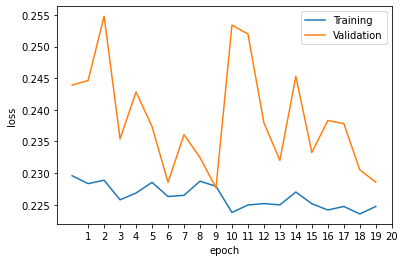

In [51]:
plt.plot(training.history['loss'], label='Training')
plt.plot(training.history['val_loss'], label='Validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xticks(range(1,21))
plt.legend(loc='upper right')
plt.show();

### Confusion Matrix

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

The predictions are probabilities and need to be converted for the following evaluations.

In [35]:
y_pred_adj = np.argmax(y_pred, axis=1)

As a reminder, 1 indicates a North Atlantic right whale signal, and 0 indicates noise.

In [43]:
cm = confusion_matrix(y_test[:,1], y_pred_adj)

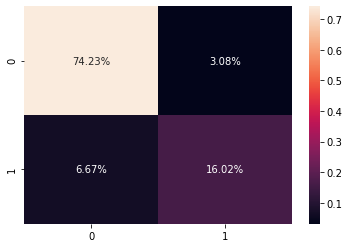

In [52]:
sns.heatmap(cm/np.sum(cm) , annot=True, fmt='.2%');

### Precision, Recall, F1

In [46]:
print(classification_report(y_test[:,1], y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      4639
         1.0       0.84      0.71      0.77      1361

    accuracy                           0.90      6000
   macro avg       0.88      0.83      0.85      6000
weighted avg       0.90      0.90      0.90      6000

